# W207 Group Project/Final
## Kaggle Competition: Random Acts of Pizza

Members:<br>
Daniel Elkin<br>
Mark Gin

Project Prompt:<br>
People post pizza requests on Reddit<br>
Build 2-class classifier<br>
Classify whether post will get pizza<br>
Practice mining features from text<br>

Reference links:
 - https://www.kaggle.com/c/random-acts-of-pizza
 - http://cs.stanford.edu/~althoff/raop-dataset/

Data Set:<br>
This training dataset contains a collection of 5671 textual requests for pizza from the Reddit community "Random Acts of Pizza" together with their outcome (successful/unsuccessful) and meta-data.

We will split the dataset into:
 - 25% for development
 - 75% for training

A separate dataset file was provided for testing purposes, of which we do not have the labels as to whether or not a pizza was received.

In [1]:
import numpy as np
import pandas as pd
import re

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.grid_search import GridSearchCV

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn import metrics

/Users/mgin/anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/mgin/anaconda/lib/python2.7/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [2]:
# import the data
df_train = pd.read_json('train.json')
df_test = pd.read_json('test.json')

# drop the target column from the data and use it for the labels
classification_column_name = 'requester_received_pizza'

train_data = df_train.drop([classification_column_name], axis=1)
train_labels = df_train[classification_column_name]

# use twenty-five percent of the training data for a dev data set
# note that we cannot use the test data set here, because we are not given their labels
train_data, dev_data, train_labels, dev_labels = train_test_split(train_data, train_labels, random_state=42)

As we will be parsing the message body of each pizza request to utilize as features for our models, we will create term-frequency matricies of the text to use in our models as features.

In [3]:
# debug function used to print the vocabularies into a text file
def output_file(output_name, output_list):
    with open(output_name, 'w') as output:
        for i in output_list:
            output.write(i.encode('UTF-8') + "\n")

def decimal_to_percent(decimal):
    return round(decimal * 100, 2)

def basic_vectorizer():
    ''' Construct term-frequency matrices for use in models '''
    
    # use title and text of the post
    text_column = 'request_text'
    train_text = train_data['request_title'] + train_data[text_column]
    dev_text = dev_data['request_title'] + dev_data[text_column]
#    train_text = train_data[text_column]
#    dev_text = dev_data[text_column]

    # construct the term-frequency count matrix
    tf_vect = CountVectorizer()
    tf_train = tf_vect.fit_transform(train_text)
    tf_dev = tf_vect.transform(dev_text)
    
    #output_file("basic_vocab.txt", tf_vect.get_feature_names())
    
    return (tf_train, tf_dev)

(tf_train, tf_dev) = basic_vectorizer()

Next we will train basic models, without tuning, for each candidate learning model:
- Logistic Regression
- Naive Bayes
- Decision Tree
  
We will train and find the accuracies of each model.  This will give us a general idea of which learning models may be most successful and can build upon them from there.

In [4]:
def train_and_evaluate_model(model, tf_train, train_labels, tf_dev, dev_labels):
    ''' Train and score a model'''
    clf = model
    clf.fit(tf_train, train_labels)
    
    # return the accuracy and F1 scores
    accuracy = clf.score(tf_dev, dev_labels) 
    predicted = clf.predict(tf_dev)
    f1_score = metrics.f1_score(predicted, dev_labels, average=None)

    return accuracy, f1_score

def print_model_scores(model_type, accuracy, f1_score):
    ''' Print the accuracy and f1 scores '''
    
    print 'The accuracy of {} model is {}%\n'.format(model_type, decimal_to_percent(accuracy))
    print 'The F1 scores are:\nFalse: {}\nTrue: {}\n'.format(*[decimal_to_percent(score) for score in f1_score])

In [5]:
# train basic models to gauge baseline performance of the models
# Logisitc Regression
# Naive Bayes
# Decision Tree
basic_lr = LogisticRegression()
basic_nb = BernoulliNB()
basic_dt = DecisionTreeClassifier()

for model, model_name in [(basic_lr, 'Logistic Regression'), (basic_nb, 'Naive Bayes'),
                  (basic_dt, 'Decision Tree')]:
    accuracy, f1_score = train_and_evaluate_model(model, tf_train, train_labels, tf_dev, dev_labels)
    print_model_scores(model_name, accuracy, f1_score)


The accuracy of Logistic Regression model is 69.21%

The F1 scores are:
False: 80.48
True: 27.17

The accuracy of Naive Bayes model is 71.98%

The F1 scores are:
False: 82.8
True: 24.53

The accuracy of Decision Tree model is 67.82%

The F1 scores are:
False: 79.02
True: 31.0



Let's attempt to build upon our basic models by introducing preprocessing algorithms for our word vocabulary vectorizer.

In [6]:
def vectorize_with_preprocessor(preprocessor_func, ngram=(1,1), mindf=1):
    ''' Construct term-frequency matrices for use in models '''
    
    # use title and text of the post
    text_column = 'request_text'
    train_text = train_data['request_title'] + train_data[text_column]
    dev_text = dev_data['request_title'] + dev_data[text_column]

    # construct the term-frequency count matrix
    tf_vect = CountVectorizer(preprocessor=preprocessor_func,
                              ngram_range=ngram,
                              min_df=mindf)
    tf = tf_vect.fit(train_text)
    
    # make the matrices global variables for convenience?
    tf_train_pp = tf.transform(train_text)
    tf_dev_pp = tf.transform(dev_text)
    
    #output_file("porter.txt", tf_vect.get_feature_names())
    #output_file("composite.txt", tf_vect.get_feature_names())
    
    return (tf_train_pp, tf_dev_pp)


In [7]:
# use porter-stemming algorithm to generalize words in the messages
# https://tartarus.org/martin/PorterStemmer/def.txt
def porter_stemming(s):
    # create a new empty string, since s is the entire message not a single word
    new_s = ""
    
    # iterate through each word in space delimited string
    for w in s.split():
        # calculate the measure, which is the number of vowel to consanant transitions
        m_cnt = 0
        if (re.search('^[^aeiou]*(([aeiou]+[^aeiou]+)+)[aeiou]*$', w)):
            measure_match = re.match('^[^aeiou]*(([aeiou]+[^aeiou]+)+)[aeiou]*$', w)
            # split on vowels to count number of transitions
            consanant_groups = re.split('[aeiou]+', measure_match.group(1))
            m_cnt = len(consanant_groups) - 1
        
        # Step 1a of porter stemming
        if re.search('sses$', w):
            w = re.sub('sses$', 'ss', w)
        elif re.search('ies$', w):
            w = re.sub('ies$', 'i', w)
        elif re.search('ss$', w):
            w = re.sub('ss$', 'i', w)
        elif re.search('s$', w):
            w = re.sub('s$', '', w)
        # Step 1b
        # Porter-Stemming says this should be m_cnt > 0, but doesn't
        # even match their own examples, tweaked to 1 and got slightly better performance
#        if (m_cnt > 1 and re.search('eed$', w)):
#            w = re.sub('eed$', 'ee', w)
#        elif (re.search('.*[aeiou].*(ed|ing)$', w)):
#            w = re.sub('(ed|ing)$', '', w)
#            # if the second or third rule of 1b is successful, we also
#            if (re.search('(at|bl|iz)$', w)):
#                w += 'e'
#            # ends in double consanant, but no l s or z
#            elif (re.search('.*([^aeiou])([^aeiou])$', w)) :
#                m = re.match('(.*)([^aeiou])([^aeiou])$', w)
#                if (m.group(3) == m.group(2) and
#                    m.group(3) != 'l' and
#                    m.group(3) != 's' and
#                    m.group(3) != 'z') :
#                    w = m.group(1) + m.group(2)
#            # measure at least one and ends in cvc
#            # but second c is not W,X,Y
#            elif (m_cnt == 1 and re.search('^.*[^aeiou][aeiou][^aeiouwxy]$', w)) :
#                w = re.sub('[^aeiouwxy]$', 'e', w)
        # Step 1c
        if (re.search('.*[aeiou].*y$', w)) :
            w = re.sub('y$', 'i', w)
        # Step 2
        if (m_cnt > 0) :
            if (re.search('ational$', w)) :
                w = re.sub('ational$', 'ate', w)
            elif (re.search('tional$', w)) :
                w = re.sub('tional$', 'tion', w)
            elif (re.search('enci$', w)) :
                w = re.sub('enci$', 'ence', w)
            elif (re.search('anci$', w)) :
                w = re.sub('anci$', 'ance', w)
            elif (re.search('izer$', w)) :
                w = re.sub('izer$', 'ize', w)
            elif (re.search('abli$', w)) :
                w = re.sub('abli$', 'able', w)
            elif (re.search('alli$', w)) :
                w = re.sub('alli$', 'al', w)
            elif (re.search('entli$', w)) :
                w = re.sub('entli$', 'ent', w)
            elif (re.search('eli$', w)) :
                w = re.sub('eli$', 'e', w)
            elif (re.search('ousli$', w)) :
                w = re.sub('ousli$', 'ous', w)
            elif (re.search('ization$', w)) :
                w = re.sub('ization$', 'ize', w)
            elif (re.search('(ation|ator)$', w)) :
                w = re.sub('(ation|ator)$', 'ate', w)
            elif (re.search('alism$', w)) :
                w = re.sub('alism$', 'al', w)
            elif (re.search('iveness$', w)) :
                w = re.sub('iveness$', 'ive', w)
            elif (re.search('fulness$', w)) :
                w = re.sub('fulness$', 'ful', w)
            elif (re.search('ousness$', w)) :
                w = re.sub('ousness$', 'ous', w)
            elif (re.search('aliti$', w)) :
                w = re.sub('aliti$', 'al', w)
            elif (re.search('iviti$', w)) :
                w = re.sub('iviti$', 'ive', w)
            elif (re.search('biliti$', w)) :
                w = re.sub('biliti$', 'ble', w)
        # Step 3
        if (m_cnt > 0) :
            if (re.search('icate$', w)) :
                w = re.sub('icate$', 'ic', w)
            elif (re.search('ative$', w)) :
                w = re.sub('ative$', '', w)
            elif (re.search('alize$', w)) :
                w = re.sub('alize$', 'al', w)
            elif (re.search('iciti$', w)) :
                w = re.sub('iciti$', 'ic', w)
            elif (re.search('ical$', w)) :
                w = re.sub('ical$', 'ic', w)
            elif (re.search('ful$', w)) :
                w = re.sub('ful$', '', w)
            elif (re.search('ness$', w)) :
                w = re.sub('ness$', '', w)
        # Step 4
        if (m_cnt > 1) :
            if (re.search('al$', w)) :
                w = re.sub('al$', '', w)
            elif (re.search('ance$', w)) :
                w = re.sub('ance$', '', w)
            elif (re.search('ence$', w)) :
                w = re.sub('ence$', '', w)
            elif (re.search('er$', w)) :
                w = re.sub('er$', '', w)
            elif (re.search('ic$', w)) :
                w = re.sub('ic$', '', w)
            elif (re.search('able$', w)) :
                w = re.sub('able$', '', w)
            elif (re.search('ible$', w)) :
                w = re.sub('ible$', '', w)
            elif (re.search('ant$', w)) :
                w = re.sub('ant$', '', w)
            elif (re.search('ement$', w)) :
                w = re.sub('ement$', '', w)
            elif (re.search('ent$', w)) :
                w = re.sub('ent$', '', w)
            elif (m_cnt > 1 and re.search('[s|t]ion$', w)) :
                w = re.sub('[s|t]ion$', '', w)
            elif (re.search('ou$', w)) :
                w = re.sub('ou$', '', w)
            elif (re.search('ism$', w)) :
                w = re.sub('ism$', '', w)
            elif (re.search('ate$', w)) :
                w = re.sub('ate$', '', w)
            elif (re.search('iti$', w)) :
                w = re.sub('iti$', '', w)
            elif (re.search('ous$', w)) :
                w = re.sub('ous$', '', w)
            elif (re.search('ive$', w)) :
                w = re.sub('ive$', '', w)
            elif (re.search('ize$', w)) :
                w = re.sub('ize$', '', w)
        # Step 5a
        if (m_cnt > 1 and re.search('e$', w)) :
            w = re.sub('e$', '', w)
        # measure at least one and ends in cvc
        # but second c is not W,X,Y
        elif (m_cnt == 1 and not re.search('^[^aeiou][aeiou][^aeiouwxy]e$', w)) :
            w = re.sub('e$', '', w)
        # Step 5b
        if (m_cnt > 1 and re.search('.*ll$', w)):
            w = re.sub('l$', '', w)
        # end of porter stemming
        # attach the word back to the new string
        new_s += (" " + w)
    return new_s

In [8]:
def stopword_preprocessor(s):    
    # remove "stop" words which bear no significant meaning in most contexts
    s = re.sub(' ?the ', r' ', s)
    s = re.sub(' ?who ', r' ', s)
    s = re.sub(' ?what ', r' ', s)
    s = re.sub(' ?them ', r' ', s)
    s = re.sub(' ?my ', r' ', s)
    s = re.sub(' ?our ', r' ', s)
    s = re.sub(' ?this ', r' ', s)
    s = re.sub(' ?that ', r' ', s)
    s = re.sub(' ?which ', r' ', s)
    s = re.sub(' ?why ', r' ', s)
    s = re.sub(' ?me ', r' ', s)
    #s = re.sub(' ?i ', r' ', s)
    #s = re.sub(' ?us ', r' ', s)
    #s = re.sub(' ?you ', r' ', s)
    s = re.sub(' ?they ', r' ', s)
    s = re.sub(' ?where ', r' ', s)
    s = re.sub(' ?and ', r' ', s)
    s = re.sub(' ?for ', r' ', s)
    s = re.sub(' ?his ', r' ', s)
    s = re.sub(' ?her ', r' ', s)
    s = re.sub(' ?to ', r' ', s)
    #s = re.sub(' ?of ', r' ', s)
    
    # let's also get rid of 'request' and 'pizza' since they show up frequently in titles
    s = re.sub('request', r'', s)
    s = re.sub('pizza', r'', s)
    
    return s

In [9]:
# Basic string preprocessor:
# lowercases all text, removes, digits and special characters
def basic_preprocessor(s):
    # make everything lowercase
    s = s.lower()
    
    # eliminate consecutive digits
    s = re.sub('([0-9])[0-9]+', r'\1', s)
    
    # eliminate all digits
    #s = re.sub('[0-9]+', r'', s)
    
    # eliminate special characters, except hyphens
    s = re.sub('[^A-Za-z0-9\s\-]+', ' ', s)
    
    # add a space between consecutive numbers/alpha
    s = re.sub('([0-9])([a-z])', '\1 \2', s)
    s = re.sub('([a-z])([0-9])', '\1 \2', s)
    
    return s

In [10]:
# uses the other preprocessors already written above
# to form a composite preprocessor
def composite_preprocessor(s):
    s = basic_preprocessor(s)
    s = stopword_preprocessor(s)
    #s = porter_stemming(s)
    
    return s

We developed different preprocessors with different functionalities:
- Basic Preprocessor
 - Lower case text, removes consecutive digits
- Stopword Preprocessor
 - Removes common, non contextual stopwords (the, that, and... etc)
- Porter-Stemming Preprocessor
 - Advanced preprocessing of vocabulary, suffix removal
 - Example: learning -> learn

We retrained new basic models, this time we use an updated vocabulary based on our vectorizer preprocessor.

In [11]:
(tf_pp_train, tf_pp_dev) = vectorize_with_preprocessor(composite_preprocessor)
    
# train basic models to gauge baseline performance of the models
# Logisitc Regression
# Naive Bayes
# Decision Tree
basic_pp_lr = LogisticRegression()
basic_pp_nb = BernoulliNB()
basic_pp_dt = DecisionTreeClassifier()

for model, model_name in [(basic_pp_lr, 'Logistic Regression'), (basic_pp_nb, 'Naive Bayes'),
                  (basic_pp_dt, 'Decision Tree')]:
    accuracy, f1_score = train_and_evaluate_model(model, tf_pp_train, train_labels,
                                                  tf_pp_dev, dev_labels)
    print_model_scores(model_name, accuracy, f1_score)


The accuracy of Logistic Regression model is 70.1%

The F1 scores are:
False: 81.24
True: 26.34

The accuracy of Naive Bayes model is 71.88%

The F1 scores are:
False: 82.81
True: 22.83

The accuracy of Decision Tree model is 65.94%

The F1 scores are:
False: 77.84
True: 26.5



In our testing, we found the best results by compositing our basic preprocessor with the stopword preprocessor.  The Porter-Stemming preprocessor seemed to actually have an adverse impact in accuracy, albeit, marginal.

Using the composite preprocessor (basic and stopword), the accuracy of for our models changed:
- Logistic Regression model from 69.21% to 70.1%
- Naive Bayes model from 71.98% to 71.88%
- Decision Tree model from 67.72% to 64.75%

Although the addition of preprocessing had only marginal impacts to Logistic Regression and Naive Bayes, in our dataset, it appears to have improved Logistic Regression, if only slightly and had a negative affect for Naive Bayes, also only slightly.  Decision Tree modeling was more adversely affected by the introduction of preprocessing.

Overall, Naive Bayes appears to be performing better than the Logistic Regression and Decision Tree models, although only about 2% better over the Logistic Regression model.

In [12]:
# Vectorize textual data with TF-IDF transformation
from sklearn.feature_extraction.text import TfidfVectorizer

def tfidf_vectorizer(preprocessor_func, ngram=(1,1)):
    # use title and text of the post
    text_column = 'request_text'
    train_text = train_data['request_title'] + train_data[text_column]
    dev_text = dev_data['request_title'] + dev_data[text_column]

    # construct the term-frequency count matrix
    tfidf_vect = TfidfVectorizer(preprocessor=preprocessor_func, ngram_range=ngram)
    tfidf = tfidf_vect.fit(train_text)
    
    tfidf_train = tfidf_vect.transform(train_text)
    tfidf_dev = tfidf_vect.transform(dev_text)
    
    return (tfidf_train, tfidf_dev)

(tfidf_train, tfidf_dev) = tfidf_vectorizer(composite_preprocessor)

basic_tfidf_lr = LogisticRegression()
basic_tfidf_nb = BernoulliNB()
basic_tfidf_dt = DecisionTreeClassifier()

for model, model_name in [(basic_tfidf_lr, 'Logistic Regression'),
                          (basic_tfidf_nb, 'Naive Bayes'),
                          (basic_tfidf_dt, 'Decision Tree')]:
    accuracy, f1_score = train_and_evaluate_model(model,
                                                  tfidf_train, train_labels,
                                                  tfidf_dev, dev_labels)
    print_model_scores(model_name, accuracy, f1_score)

The accuracy of Logistic Regression model is 74.85%

The F1 scores are:
False: 85.45
True: 7.3

The accuracy of Naive Bayes model is 71.88%

The F1 scores are:
False: 82.81
True: 22.83

The accuracy of Decision Tree model is 63.76%

The F1 scores are:
False: 75.98
True: 26.21



We attempted to also try a TF-IDF (Term Frequncy) vectorizer for our training vocabulary to see if using a different vectorizer method would bear significant improvment to our models.  We found a good improvment in overall accuracy of our Logistic Regression model but did not find any signifcant differences in applying a different vectorizer to Naive Bayes whereas  Decision Tree model was adversely affected:
 - Logistic Regression 70.1 to 74.85
 - Naive Bayes 71.88 to 71.88
 - Decision Tree 64.75 to 62.57

An additional potential improvment to both models is to modify our count vectorizer to include bi-gram text, as opposed to uni-gram text which is currently being used.

In [13]:
print "Using Count Vectorizer and bi-gram vocabulary:"
bi_gram = (1,2)
(tf_bi_train, tf_bi_dev) = vectorize_with_preprocessor(composite_preprocessor, bi_gram)
    
# train basic models to gauge baseline performance of the models
# Logisitc Regression
# Naive Bayes
# Decision Tree
basic_bi_lr = LogisticRegression()
basic_bi_nb = BernoulliNB()
basic_bi_dt = DecisionTreeClassifier()

for model, model_name in [(basic_bi_lr, 'Logistic Regression'), (basic_bi_nb, 'Naive Bayes'),
                  (basic_bi_dt, 'Decision Tree')]:
    accuracy, f1_score = train_and_evaluate_model(model, tf_bi_train, train_labels,
                                                  tf_bi_dev, dev_labels)
    print_model_scores(model_name, accuracy, f1_score)
    
print "Using TF-IDF Vectorizer and bi-gram vocabulary:"
(tfidf_bi_train, tfidf_bi_dev) = tfidf_vectorizer(composite_preprocessor, bi_gram)

basic_tfidf_bi_lr = LogisticRegression()
basic_tfidf_bi_nb = BernoulliNB()
basic_tfidf_bi_dt = DecisionTreeClassifier()

for model, model_name in [(basic_tfidf_bi_lr, 'Logistic Regression'),
                          (basic_tfidf_bi_nb, 'Naive Bayes'),
                          (basic_tfidf_bi_dt, 'Decision Tree')]:
    accuracy, f1_score = train_and_evaluate_model(model,
                                                  tfidf_bi_train, train_labels,
                                                  tfidf_bi_dev, dev_labels)
    print_model_scores(model_name, accuracy, f1_score)


Using Count Vectorizer and bi-gram vocabulary:
The accuracy of Logistic Regression model is 70.59%

The F1 scores are:
False: 82.03
True: 19.07

The accuracy of Naive Bayes model is 73.96%

The F1 scores are:
False: 85.0
True: 1.5

The accuracy of Decision Tree model is 68.71%

The F1 scores are:
False: 80.32
True: 23.67

Using TF-IDF Vectorizer and bi-gram vocabulary:
The accuracy of Logistic Regression model is 74.46%

The F1 scores are:
False: 85.34
True: 0.77

The accuracy of Naive Bayes model is 73.96%

The F1 scores are:
False: 85.0
True: 1.5

The accuracy of Decision Tree model is 63.27%

The F1 scores are:
False: 75.12
True: 29.87



The bi-gram vocabularies, using both the Count and TF-IDF vectorizers had mixed results, with marginal improvments and degredation in overall accuracy for various models.  It should also be noted that when there was improvment, the F1 score for sucessful pizza requests dropped significantly.

We will attempt to tune our default modeling by gridsearching over various hyperparameters.

In [14]:
# generic grid search which can field different models and hyperparameters
# and output the best results
def gridsearch_model(model, parameters, tf_dev, dev_labels): 
    gridsearch = GridSearchCV(estimator=model,
                              param_grid=parameters)
    gridsearch.fit(tf_dev, dev_labels)
    
    print "Best parameters:"
    print gridsearch.best_params_
    
# c_values for logistic regression
c_values = {'C': [0.001, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0,
                  5.0, 10.0, 15.0, 20.0, 25.0, 50.0, 75.0, 100.0]}

# logistic regression tuning
gridsearch_model(basic_pp_lr, c_values, tf_pp_dev, dev_labels)

# use optimal parameters
tuned_lr = LogisticRegression(C=0.01)
tuned_lr.fit(tf_pp_train, train_labels)
lr_accuracy = tuned_lr.score(tf_pp_dev, dev_labels) 
lr_predicted = tuned_lr.predict(tf_pp_dev)
lr_f1_score = metrics.f1_score(lr_predicted, dev_labels, average=None)
print_model_scores("Tuned Logistic Regression with CV", lr_accuracy, lr_f1_score)

gridsearch_model(basic_tfidf_lr, c_values, tfidf_dev, dev_labels)

# use optimal parameters
tuned_tfidf_lr = LogisticRegression(C=0.01)
tuned_tfidf_lr.fit(tfidf_train, train_labels)
lr_tfidf_accuracy = tuned_tfidf_lr.score(tfidf_dev, dev_labels) 
lr_tfidf_predicted = tuned_tfidf_lr.predict(tfidf_dev)
lr_tfidf_f1_score = metrics.f1_score(lr_tfidf_predicted, dev_labels, average=None)
print_model_scores("Tuned Logistic Regression with TF-IDF", lr_tfidf_accuracy, lr_tfidf_f1_score)

Best parameters:
{'C': 0.001}
The accuracy of Tuned Logistic Regression with CV model is 74.75%

The F1 scores are:
False: 85.35
True: 8.6

Best parameters:
{'C': 0.001}
The accuracy of Tuned Logistic Regression with TF-IDF model is 74.55%

The F1 scores are:
False: 85.42
True: 0.0



/Users/mgin/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [15]:
# naive bayes tuning
params = {'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 1.0,]}
gridsearch_model(basic_pp_nb, params, tf_pp_dev, dev_labels)

tuned_nb = BernoulliNB(alpha=0.85)
tuned_nb.fit(tf_pp_train, train_labels)
nb_accuracy = tuned_nb.score(tf_pp_dev, dev_labels)
nb_predicted = tuned_nb.predict(tf_pp_dev)
nb_f1_score = metrics.f1_score(nb_predicted, dev_labels, average=None)
print_model_scores("Tuned Naive Bayes", nb_accuracy, nb_f1_score)

# TF-IDF vocabulary w/ Naive Bayes tuning
gridsearch_model(basic_tfidf_nb, params, tf_pp_dev, dev_labels)
# use optimal parameters
tuned_tfidf_nb = BernoulliNB(alpha=0.85)
tuned_tfidf_nb.fit(tfidf_train, train_labels)
nb_tfidf_accuracy = tuned_tfidf_nb.score(tfidf_dev, dev_labels) 
nb_tfidf_predicted = tuned_tfidf_lr.predict(tfidf_dev)
nb_tfidf_f1_score = metrics.f1_score(nb_tfidf_predicted, dev_labels, average=None)
print_model_scores("Tuned Naive Bayes with TF-IDF", nb_tfidf_accuracy, nb_tfidf_f1_score)

Best parameters:
{'alpha': 0.95}
The accuracy of Tuned Naive Bayes model is 71.58%

The F1 scores are:
False: 82.49
True: 24.67

Best parameters:
{'alpha': 0.95}
The accuracy of Tuned Naive Bayes with TF-IDF model is 71.58%

The F1 scores are:
False: 85.42
True: 0.0



Interestingly, using grid search did not find us hyperparameter values, C and alpha, for Logistic Regression and Naive Bayes, respectively, that improved overall accuracy of the models. Trial and error proved to be more effective.

In the case of tuning Naive Bayes, the differences in accuracy was marginal.  It's also noted that using a TF-IDF model vs Count Vectorized vocabulary features did not produce significant improvements while tuning the model.

Logistic Regression showed slight improvement with tuning, however, we are getting 0% accuracy for "True" or successful pizza requests, meaning while the model has good accuracy overall with the tuned parameters, its accuracy for predicting sucessful requests is zero.  Therefore the tuning of parameters to values found in gridsearch is not ideal and requires some manual finessing.

Another reason, it is possible there is a class imbalance in our training data and the model is merely always guessing False/unsuccessful pizza requests to obtain a higher accuracy.  If there is a class imbalance in our training data, it may be difficult for the model to distinguish between sucessful and unsucessful features.

In [16]:
# doing some exploration to find out if there is a class imbalance in our training data
# by counting the outcome classes in our training set
def class_counts():
    counts = [0, 0]
    for i in train_labels:
        counts[i] += 1
    
    for i in range(len(counts)):
        print i, counts[i]
        
class_counts()

0 2293
1 737


We observe from our class counting that there is indeed some weight imbalance in our training set.   There are far more classes in the unsucessful requests compared to the sucessful requests, roughly 3 to 1, in the favor of unsuccessful requests.  We can use this knowledge to weight our classes for training to improve prediction accuracy.

In [17]:
# There is some class imbalance, so lets try weighting based on the ratio of classes
weight_dict = {0: 0.33, 1: .67}
lr_weight = LogisticRegression(C=0.001, class_weight=weight_dict)
lr_weight.fit(tf_pp_train, train_labels)
lrw_accuracy = lr_weight.score(tf_pp_dev, dev_labels) 
lrw_predicted = lr_weight.predict(tf_pp_dev)
lrw_f1_score = metrics.f1_score(lrw_predicted, dev_labels, average=None)
print_model_scores("Weighed Logistic Regression", lrw_accuracy, lrw_f1_score)

The accuracy of Weighed Logistic Regression model is 74.55%

The F1 scores are:
False: 85.34
True: 3.75



Adjusting the weighting for logistic improved show only marginal improvement for the True or sucessful request prediction.

In [42]:
# introduce other features from the dataset to combine with text features we extracted
# from the message bodies
import scipy as sp

num_train_examples = train_data.shape[0]
num_dev_examples = dev_data.shape[0]

# We start with the preprocessed vocabulary as a basis

tf_train_plus = sp.sparse.hstack((
                    tf_pp_train, 
                    train_data['number_of_upvotes_of_request_at_retrieval'].values.reshape(num_train_examples, 1), 
                    train_data['request_number_of_comments_at_retrieval'].values.reshape(num_train_examples, 1),
                    train_data['requester_number_of_posts_on_raop_at_retrieval'].values.reshape(num_train_examples, 1),
                    #train_data['requester_days_since_first_post_on_raop_at_request'].values.reshape(num_train_examples, 1),
                ), format='csr')

tf_dev_plus = sp.sparse.hstack((
                    tf_pp_dev, 
                    dev_data['number_of_upvotes_of_request_at_retrieval'].values.reshape(num_dev_examples, 1), 
                    dev_data['request_number_of_comments_at_retrieval'].values.reshape(num_dev_examples, 1),
                    dev_data['requester_number_of_posts_on_raop_at_retrieval'].values.reshape(num_dev_examples, 1),
                    #dev_data['requester_days_since_first_post_on_raop_at_request'].values.reshape(num_dev_examples, 1),
                ), format='csr')
    
    
# train basic models to gauge baseline performance of the models
# Logisitc Regression
# Naive Bayes
# Decision Tree
# calling af for added features
basic_af_lr = LogisticRegression()
basic_af_nb = BernoulliNB()
basic_af_dt = DecisionTreeClassifier()

for model, model_name in [(basic_af_lr, 'Logistic Regression'), (basic_af_nb, 'Naive Bayes'),
                  (basic_af_dt, 'Decision Tree')]:
    accuracy, f1_score = train_and_evaluate_model(model, tf_train_plus, train_labels,
                                                  tf_dev_plus, dev_labels)
    print_model_scores(model_name, accuracy, f1_score)

The accuracy of Logistic Regression model is 76.63%

The F1 scores are:
False: 84.99
True: 47.32

The accuracy of Naive Bayes model is 71.98%

The F1 scores are:
False: 82.88
True: 22.89

The accuracy of Decision Tree model is 80.1%

The F1 scores are:
False: 86.8
True: 59.56



In [39]:
# We've progressively showed mining features from text, maybe we should also show more about
# how other features were experimented with...

num_train_examples = train_data.shape[0]
num_dev_examples = dev_data.shape[0]

# We start with the preprocessed vocabulary as a basis
# but we add a single field from the dataset
def addFeature(field, tf_train, tf_dev):
    new_train_col = train_data[field].values.reshape(num_train_examples,1)
    new_dev_col = dev_data[field].values.reshape(num_dev_examples,1)
    tf_train_plus = sp.sparse.hstack((tf_train, 
                                     new_train_col, 
                                     ), format='csr')
    tf_dev_plus = sp.sparse.hstack((tf_dev, 
                                   new_dev_col, 
                                   ), format='csr')
    return tf_train_plus, tf_dev_plus

# print the table header
print '%50.50s %20.20s %6.6s %5.5s %5.5s' %("Attribue Name", "Model", "Acc", "False", "True")

# Loop through all the different attribute fields in the dataset,
# picking one out at a time to add to the feature vector to see how a single one improves (or not)
for k in sorted(train_data.columns):
    # skip these since we already have the text features
    if (k == "request_text" or k == "request_title"):
        continue
    # these are giving the transform some compile errors, skipping them
    elif (k == "giver_username_if_known" or
          k == "request_id" or
          k == "request_text_edit_aware" or
          k == "requester_subreddits_at_request" or
          k == "requester_user_flair" or
          k == "requester_username"):
        continue
    # train basic models to gauge baseline performance of the models
    # Logisitc Regression, Naive Bayes, Decision Tree
    # calling af for added features
    basic_af_lr = LogisticRegression()
    basic_af_nb = BernoulliNB()
    basic_af_dt = DecisionTreeClassifier()

    # use this to flag if its the first model to print in the attribute
    # used for formatting the print later
    att_flag = 0
    
    tf_train_plus, tf_dev_plus = addFeature(k, tf_pp_train, tf_pp_dev)
    
    for model, model_name in [(basic_af_lr, 'Logistic Regression'), (basic_af_nb, 'Naive Bayes'),
                      (basic_af_dt, 'Decision Tree')]:
        accuracy, f1_score = train_and_evaluate_model(model, tf_train_plus, train_labels,
                                                      tf_dev_plus, dev_labels)
        #print_model_scores(model_name, accuracy, f1_score)
        
        # print a table of values
        # attribute       model     accuracy f1_false f1_true
        #                 model     accuracy f1_false f1_true
        if (att_flag == 1):
            print '%50.50s %20.20s %1.4f %1.4f %1.4f' %("", model_name, accuracy, f1_score[0], f1_score[1])
        else:
            print '%50.50s %20.20s %1.4f %1.4f %1.4f' %(k, model_name, accuracy, f1_score[0], f1_score[1]) 
            att_flag = 1

                                     Attribue Name                Model    Acc False  True
       number_of_downvotes_of_request_at_retrieval  Logistic Regression 0.7010 0.8129 0.2562
                                                            Naive Bayes 0.7178 0.8276 0.2234
                                                          Decision Tree 0.6673 0.7838 0.2790
         number_of_upvotes_of_request_at_retrieval  Logistic Regression 0.7040 0.8146 0.2654
                                                            Naive Bayes 0.7188 0.8281 0.2283
                                                          Decision Tree 0.6703 0.7845 0.2989
                                   post_was_edited  Logistic Regression 0.7455 0.8542 0.0000
                                                            Naive Bayes 0.7188 0.8281 0.2283
                                                          Decision Tree 0.6624 0.7799 0.2760
           request_number_of_comments_at_retrieval  Logistic Regression 

By introducing additional features from our dataset beyond the textual vocabulary, we were able to improve accuracy from our "basic" models.
- Logistic Regression model from 69.21% to 70.99%
- Naive Bayes model from 71.98% to 71.98%
- Decision Tree model from 67.72% to 71.58%

In [20]:
# Let's try combining some things for Logistic Regression
# Using the uni-gram vocabulary plus additional features
# We'll tune the model's C value (hyper parameter)
# And apply weighting to see what kind of accuracy we can produce

weight_dict = {0: 0.4, 1: .6}
lr_final = LogisticRegression(C=0.01, class_weight=weight_dict)

#gridsearch_model(lr_final, c_values, tf_dev_plus, dev_labels)

lr_final.fit(tf_train_plus, train_labels)
lr_final_accuracy = lr_final.score(tf_dev_plus, dev_labels) 
lr_final_predicted = lr_final.predict(tf_dev_plus)
lr_final_f1 = metrics.f1_score(lr_final_predicted, dev_labels, average=None)
print_model_scores("Logistic Regression", lr_final_accuracy, lr_final_f1)

The accuracy of Logistic Regression model is 74.55%

The F1 scores are:
False: 85.15
True: 11.07



By combing various improvments to the Logistic Regression model, we were able to predict with approximately 75% accuracy of our development dataset.  This included tuning of hyperparameters, weighting the training dataset for class imbalance, and introducing features beyond the textual vocabulary.

We next attempt to improve the performance of our Logistic Regression model by first training such a model with L1 regularization and using only the features in that model that are non-zero as the input for a model that uses L2 regularization. We are effectively removing unimportant features.

In [21]:
# fit an L1 model 
lr_with_l1 = LogisticRegression(penalty='l1', C=.1, tol=.01)
lr_with_l1.fit(tf_train_plus, train_labels)

# find the features whose weights have not been reduced to 0
non_zero_feature_indices = lr_with_l1.coef_.nonzero()[1]

# use only those features as the input to the L2 model
tf_train_reduced = tf_train_plus[:, non_zero_feature_indices]
tf_dev_reduced = tf_dev_plus[:, non_zero_feature_indices]

# see how many features we've eliminated
features_remaining = tf_train_reduced.shape[1]

print '{} features have been removed, and {} remain.'.format(
    tf_train_plus.shape[1] - features_remaining, features_remaining) 

# score the revised model
lr_reduced = LogisticRegression(C=0.01, class_weight=weight_dict).fit(tf_train_reduced, train_labels)
lr_predicted = lr_reduced.predict(tf_dev_reduced)
lr_accuracy = lr_reduced.score(tf_dev_reduced, dev_labels)
lr_f1_score = metrics.f1_score(lr_predicted, dev_labels, average=None)
print_model_scores("Logistic Regression", lr_accuracy, lr_final_f1)

11682 features have been removed, and 90 remain.
The accuracy of Logistic Regression model is 74.65%

The F1 scores are:
False: 85.15
True: 11.07



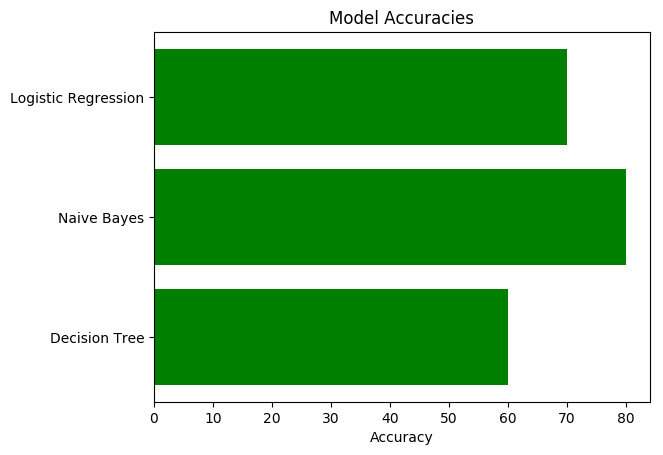

In [22]:
# TODO: this is place holder code for now

# bar graph of the different accuracies
import matplotlib.pyplot as plt
plt.rcdefaults()

fig, ax = plt.subplots()

# Example data
models = ('Logistic Regression', 'Naive Bayes', 'Decision Tree')
y_pos = np.arange(len(models))
# TODO: fill in with actual accuracy from various model permutations
accuracy_scores = [70,80,60]
error = [5,5,5]

#ax.barh(y_pos, accuracy_scores, xerr=error, align='center',
#        color='green', ecolor='black')
ax.barh(y_pos, accuracy_scores, align='center',
        color='green')
ax.set_yticks(y_pos)
ax.set_yticklabels(models)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Accuracy')
ax.set_title('Model Accuracies')

plt.show()